# Deep Learning Assignment - 01 , Problem - 01, Group - 029
# Vision Dataset - Animal Image Classification 


## Library Imports

In [25]:
import os
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

## Validate GPU Availability

In [26]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

1 Physical GPUs, 1 Logical GPUs


## Load the dataset and validate the data load

In [27]:
#train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

#dataset = train_datagen.flow_from_directory("/home/suvo/Documents/LargeDatasets/CNNDatasets/Cats-Dogs-Pandas/animals", target_size=(32, 32), batch_size=32, class_mode='binary')

In [28]:
listdir("/home/suvo/Documents/LargeDatasets/CNNDatasets/Cats-Dogs-Pandas/animals")

['cats', 'dogs', 'panda']

In [29]:
folder = "/home/suvo/Documents/LargeDatasets/CNNDatasets/Cats-Dogs-Pandas/animals"
# folder1 = "/home/suvo/Documents/LargeDatasets/CNNDatasets/Cats-Dogs-Pandas/animals"

imageList=[]
classList=[]

for file1 in listdir(folder):
    file2 = folder + "/" + file1
    for file3 in listdir(file2):
        file4 = file2 + "/" + file3
        image = tf.keras.preprocessing.image.load_img(file4, target_size=(128, 128))
        image = tf.keras.preprocessing.image.img_to_array(image)
        imageList.append(image)
        classList.append(file1)

# Check whether all the images has been parsed
print(f"Length of the image list - {len(imageList)}")
print(f"Length of the class list - {len(classList)}")

Length of the image list - 3000
Length of the class list - 3000


#### Display four images from each of the classes

In [30]:
# test

## Data Preprocessing and Preparation for Neural Network Modelling

In [31]:
# We will convert this list into numpy array
imageArray = np.asarray(imageList)
classArray = np.asarray(classList)

print(f"Shape of the image numpy array - {imageArray.shape}")
print(f"Shape of the class numpy array - {classArray.shape}")

Shape of the image numpy array - (3000, 128, 128, 3)
Shape of the class numpy array - (3000,)


In [32]:
# The type of the imageArray and classArray should now be an ndarray from numpy
type(imageArray)

numpy.ndarray

#### Normalizing our image array
we will want all our pixel values to be between 0 and 1 (normalized), in order for the neural net to train faster

In [33]:
imageArray = imageArray/255.0

#### Reshaping the image

We are flattening every image meaning we're going to transform each of the dimensions of the image for all the images of the array by flattening all the pixels into a single one vector and we will do that through reshape


In [34]:
imageArray = imageArray.reshape(-1, imageArray.shape[1]*imageArray.shape[2]*imageArray.shape[3])
imageArray.shape

(3000, 49152)

#### Label Encoding the class array

In [35]:
# Label encoding for "cats", "dogs", "pandas"
encoder = LabelEncoder()
classArray = encoder.fit_transform(classArray)

# Convert to categorical
classArray = tf.keras.utils.to_categorical(classArray)
classArray.shape

(3000, 3)

## Train-Test Split

In [36]:
# Perform the split
features_train, features_test, target_train, target_test = train_test_split(imageArray, classArray, test_size=0.3, 
                                                                            random_state=101)

# We will further split the training set into validatoion to evaluate the Neural Network training
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.3, 
                                                                            random_state=101)

print("Training Features shape: ", features_train.shape)
print("Training Target shape: ", target_train.shape)

print("Validation Features shape: ", features_val.shape)
print("Validation Target shape: ", target_val.shape)

print("Test Features shape: ", features_test.shape)
print("Training Target shape: ", target_test.shape)

Training Features shape:  (1470, 49152)
Training Target shape:  (1470, 3)
Validation Features shape:  (630, 49152)
Validation Target shape:  (630, 3)
Test Features shape:  (900, 49152)
Training Target shape:  (900, 3)


## Building the ANN

### Global Model Constants

In [37]:
# Define some global Model Constants

INPUT_SHAPE = (imageArray.shape[1], )
OUTPUT_UNITS = 3
HIDDEN_UNITS= 128
ACTIVATION_HIDDEN = tf.keras.activations.relu
ACTIVATION_OUTPUT = tf.keras.activations.softmax
LEARNING_RATE = 1e-3
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
LOSS_FUNCTION = tf.keras.losses.categorical_crossentropy
L2_REGULARIZER = tf.keras.regularizers.L2(0.001)
DROPOUT_RATE = 0.5

EPOCHS = 100

In [38]:
# Define the Metrics - These are the metrics we will evaluate during training

METRICS = [tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')]

In [39]:
# Defining a function which will build and compile the model

'''
This will build and compile a model with one hidden layer and 16 neurons
'''
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN, 
                                input_shape=INPUT_SHAPE))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN))
    model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [40]:
'''
This will build a deep neural network model with multiple hidden layers and implement 
L2 regularization
Dropout regularization
'''

def make_DNNModel(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.models.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN, kernel_regularizer=L2_REGULARIZER))
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN, kernel_regularizer=L2_REGULARIZER))
    model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [41]:
# Defining a function to plot training loss vs validation loss

'''
This function will take a epoch model from training a neural network
Will plot training loss vs validation loss
'''

def plotTrainLossVsValLoss(epochs_history):
    plt.figure(figsize=(12, 8))
    loss_train = epochs_history.history['loss']
    loss_val = epochs_history.history['val_loss']

    plt.figure(figsize=(12, 8))

    loss_train = epochs_history.history['loss']
    loss_val = epochs_history.history['val_loss']

    epochs = range(1, (EPOCHS + 1))
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training Loss vs Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [42]:
# Defining a function to plot training accuracy vs validation accuracy

'''
This function will take a epoch model from training a neural network
Will plot training accuracy vs validation accuracy
'''

def plotTrainAccuracyVsValAccuracy(epochs_history):
    plt.figure(figsize=(12, 8))

    loss_train = epochs_history.history['accuracy']
    loss_val = epochs_history.history['val_accuracy']

    epochs = range(1, (EPOCHS + 1))
    plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

#### Compile the Model and Check the summary

In [43]:
# Lets build the model and see the mmodel summary

model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 6,324,995
Trainable params: 6,324,995
Non-trainable params: 0
____________________________________________

## Training the Model

In [44]:
# we will now train the model on training and validation data
# Now use the function to plot the confusion matrix

start = datetime.now()
epochs_history_simple = model.fit(features_train, target_train, epochs=EPOCHS,
                          validation_data=(features_val, target_val),
                          verbose=1)
end = datetime.now()
print(f"The training of simple model completed in time - {end - start}")

/46 [==============================] - 0s 7ms/step - loss: 0.8598 - tp: 161.8936 - fp: 20.0851 - tn: 1514.3830 - fn: 605.3404 - accuracy: 0.7287 - precision: 0.8906 - recall: 0.2123 - auc: 0.7467 - val_loss: 0.9431 - val_tp: 97.0000 - val_fp: 12.0000 - val_tn: 1248.0000 - val_fn: 533.0000 - val_accuracy: 0.7116 - val_precision: 0.8899 - val_recall: 0.1540 - val_auc: 0.7063
Epoch 51/100
46/46 [==============================] - 0s 7ms/step - loss: 0.9023 - tp: 144.0426 - fp: 20.9149 - tn: 1513.5532 - fn: 623.1915 - accuracy: 0.7192 - precision: 0.8772 - recall: 0.1841 - auc: 0.7204 - val_loss: 0.9192 - val_tp: 115.0000 - val_fp: 22.0000 - val_tn: 1238.0000 - val_fn: 515.0000 - val_accuracy: 0.7159 - val_precision: 0.8394 - val_recall: 0.1825 - val_auc: 0.7290
Epoch 52/100
46/46 [==============================] - 0s 7ms/step - loss: 0.8898 - tp: 147.3617 - fp: 15.4043 - tn: 1519.0638 - fn: 619.8723 - accuracy: 0.7201 - precision: 0.9077 - recall: 0.1790 - auc: 0.7328 - val_loss: 0.9226 - 

#### Check Performance Graphs

<Figure size 864x576 with 0 Axes>

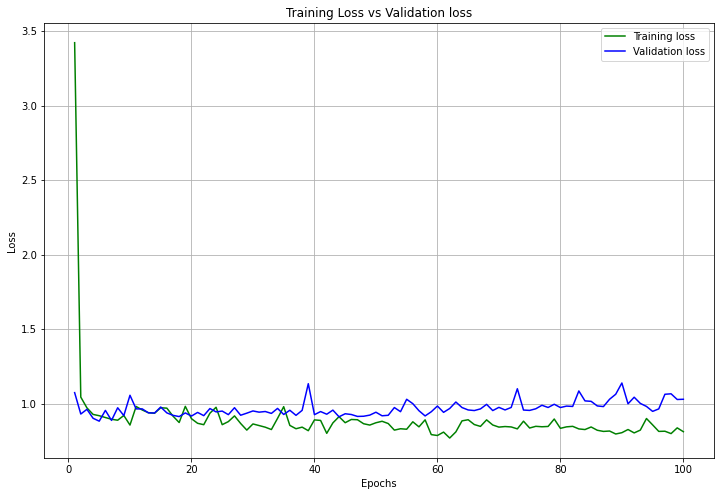

In [45]:
# Plot training loss vs validation loss
plotTrainLossVsValLoss(epochs_history=epochs_history_simple)

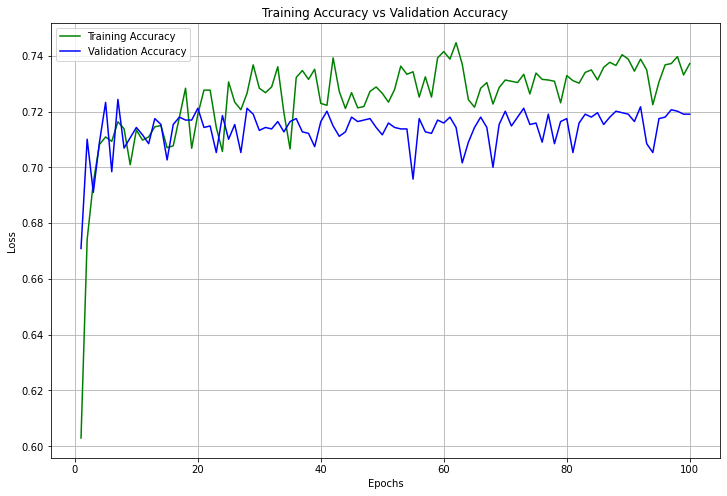

In [46]:
# Plot Training accuracy vs Validation accuracy
plotTrainAccuracyVsValAccuracy(epochs_history=epochs_history_simple)

## Model Prediction

#### We will run the predictions and display the confusion matrix and classification report

In [47]:
# In order to use it in Confusion Matrix because its a multiclass prediction
target_predictions = np.argmax(model.predict(features_test), axis = 1)
target_test = np.argmax(target_test, axis=1)

In [48]:
print("Confusion Matrix")
print("\n")
print(confusion_matrix(target_test, target_predictions))
print("\n")
print('Classification Report')
print("\n")
print(classification_report(target_test, target_predictions))

Confusion Matrix


[[297   4   9]
 [284   6  21]
 [112   0 167]]


Classification Report


              precision    recall  f1-score   support

           0       0.43      0.96      0.59       310
           1       0.60      0.02      0.04       311
           2       0.85      0.60      0.70       279

    accuracy                           0.52       900
   macro avg       0.63      0.53      0.44       900
weighted avg       0.62      0.52      0.43       900

